Pipelines: Mass Total + Source Inversion
========================================

By chaining together three searches this script fits strong lens `Imaging`, where in the final model:
.
 - The lens galaxy's light is omitted from the data and model.
 - The lens galaxy's total mass distribution is an `EllPowerLaw`.
 - The source galaxy is an `Inversion`.

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import autofit as af
import autolens as al
import autolens.plot as aplt

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


__Dataset + Masking__ 

Load, plot and mask the `Imaging` data.

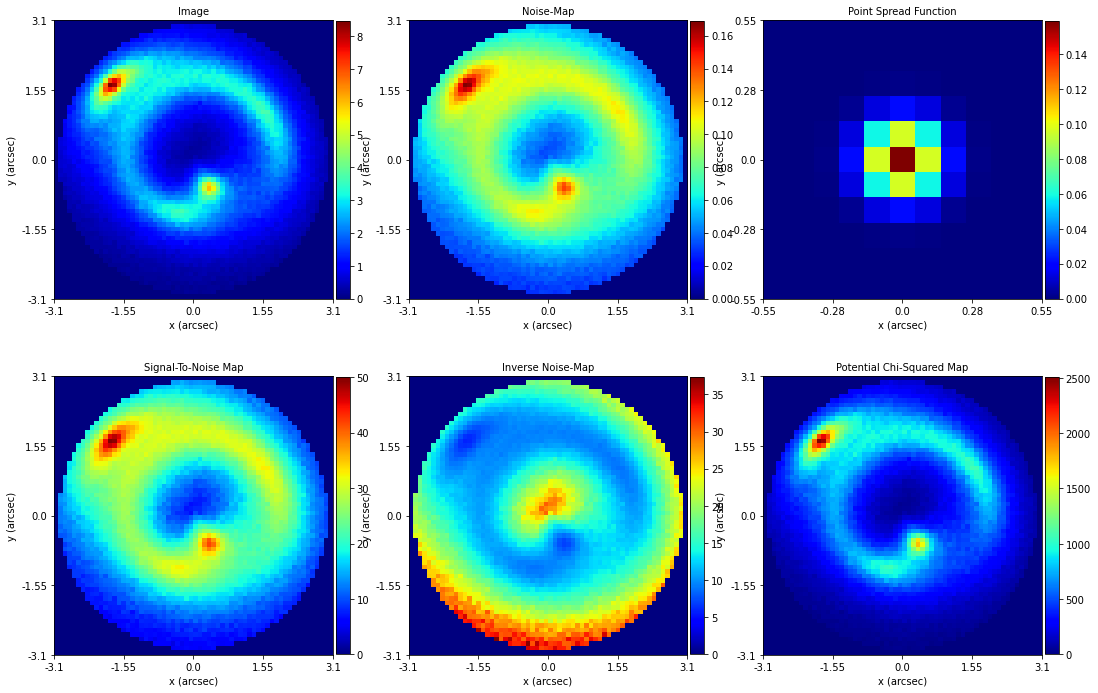

In [2]:
dataset_name = "mass_sie__source_sersic_x2"
dataset_path = path.join("dataset", "imaging", "no_lens_light", dataset_name)

imaging = al.Imaging.from_fits(
    image_path=path.join(dataset_path, "image.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    pixel_scales=0.1,
)

mask = al.Mask2D.circular(
    shape_native=imaging.shape_native, pixel_scales=imaging.pixel_scales, radius=3.0
)

imaging = imaging.apply_mask(mask=mask)

imaging_plotter = aplt.ImagingPlotter(imaging=imaging)
imaging_plotter.subplot_imaging()

__Paths__

The path the results of all chained searches are output:

In [3]:
path_prefix = path.join("imaging", "pipelines")

__Redshifts__

The redshifts of the lens and source galaxies, which are used to perform unit converions of the model and data (e.g. 
from arc-seconds to kiloparsecs, masses to solar masses, etc.).

In [4]:
redshift_lens = 0.5
redshift_source = 1.0

__Model + Search + Analysis + Model-Fit (Search 1)__

In search 1 we fit a lens model where:

 - The lens galaxy's total mass distribution is an `EllIsothermal` with `ExternalShear` [7 parameters].
 
 - The source galaxy's light is a parametric `EllSersic` [7 parameters].

The number of free parameters and therefore the dimensionality of non-linear parameter space is N=14.

In [5]:
model = af.Collection(
    galaxies=af.Collection(
        lens=af.Model(
            al.Galaxy,
            redshift=redshift_lens,
            mass=al.mp.EllIsothermal,
            shear=al.mp.ExternalShear,
        ),
        source=af.Model(al.Galaxy, redshift=redshift_source, bulge=al.lp.EllSersic),
    )
)

search = af.DynestyStatic(
    path_prefix=path_prefix,
    name="search[1]_mass[sie]_source[parametric]",
    unique_tag=dataset_name,
    nlive=50,
)

analysis = al.AnalysisImaging(dataset=imaging)

result_1 = search.fit(model=model, analysis=analysis)

/home/jammy/venvs/PyAuto/lib/python3.8/site-packages/dynesty/dynesty.py:390: UserWarning: A note of caution: having `nlive < ndim * (ndim + 1) // 2` may result in unconstrained bounding distributions.
  warnings.warn("A note of caution: "
2021-05-10 14:56:06,016 - root - INFO - No Dynesty samples found, beginning new non-linear search. 
2it [00:00,  9.63it/s, +50 | bound: 0 | nc: 1 | ncall: 52 | eff(%): 100.000 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:  1.099 >  0.059]
2021-05-10 14:56:06,243 - root - INFO - 5000 Iterations: Performing update (Visualization, outputting samples, etc.).
2021-05-10 14:56:06,372 - root - INFO - 10000 Iterations: Performing update (Visualization, outputting samples, etc.).
2021-05-10 14:56:06,487 - root - INFO - 15000 Iterations: Performing update (Visualization, outputting samples, etc.).


__Model + Search + Analysis + Model-Fit (Search 2)__

We use the results of search 1 to create the lens model fitted in search 2, where:

 - The lens galaxy's total mass distribution is an `EllIsothermal` and `ExternalShear` [Parameters fixed to 
 results of search 1].
 
 - The source-galaxy's light uses a `VoronoiMagnification` pixelization [2 parameters].
 
 - This pixelization is regularized using a `Constant` scheme [1 parameter]. 

The number of free parameters and therefore the dimensionality of non-linear parameter space is N=3.

This search allows us to very efficiently set up the resolution of the pixelization and regularization coefficient 
of the regularization scheme, before using these models to refit the lens mass model.

In [6]:
model = af.Collection(
    galaxies=af.Collection(
        lens=af.Model(
            al.Galaxy,
            redshift=redshift_lens,
            mass=result_1.instance.galaxies.lens.mass,
            shear=result_1.instance.galaxies.lens.shear,
        ),
        source=af.Model(
            al.Galaxy,
            redshift=redshift_source,
            pixelization=al.pix.VoronoiMagnification,
            regularization=al.reg.Constant,
        ),
    )
)

search = af.DynestyStatic(
    path_prefix=path_prefix,
    name="search[2]_mass[sie]_source[inversion_initialization]",
    unique_tag=dataset_name,
    nlive=20,
)

analysis = al.AnalysisImaging(dataset=imaging)

result_2 = search.fit(model=model, analysis=analysis)

2021-05-10 14:56:06,939 - root - INFO - No Dynesty samples found, beginning new non-linear search. 
0it [00:00, ?it/s]/home/jammy/venvs/PyAuto/lib/python3.8/site-packages/numba/core/ir_utils.py:2067: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'slim_indexes' of function 'furthest_grid_2d_slim_index_from'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../PyAutoArray/autoarray/structures/grids/two_d/grid_2d_util.py", line 675:
@decorator_util.jit()
def furthest_grid_2d_slim_index_from(
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
2it [00:04,  2.33s/it, +20 | bound: 0 | nc: 1 | ncall: 22 | eff(%): 100.000 | loglstar:   -inf < -12152.142 <    inf | logz: -12155.977 +/-    nan | dlogz:  1.099 >  0.029]
2021-05-10 14:56:11,614 - root - INFO - 5000 Iterations: Performing upd

__Model + Search (Search 3)__

We use the results of searches 1 and 2 to create the lens model fitted in search 3, where:

 - The lens galaxy's total mass distribution is an `EllIsothermal` and `ExternalShear` [7 parameters: priors 
 initialized from search 1].
 
 - The source-galaxy's light uses a `VoronoiMagnification` pixelization [parameters fixed to results of search 2].
 
 - This pixelization is regularized using a `Constant` scheme [parameters fixed to results of search 2]. 

The number of free parameters and therefore the dimensionality of non-linear parameter space is N=3.

This search allows us to very efficiently set up the resolution of the pixelization and regularization coefficient 
of the regularization scheme, before using these models to refit the lens mass model.

In [7]:
model = af.Collection(
    galaxies=af.Collection(
        lens=af.Model(
            al.Galaxy,
            redshift=redshift_lens,
            mass=result_1.model.galaxies.lens.mass,
            shear=result_1.model.galaxies.lens.shear,
        ),
        source=af.Model(
            al.Galaxy,
            redshift=redshift_source,
            pixelization=result_2.instance.galaxies.source.pixelization,
            regularization=result_2.instance.galaxies.source.regularization,
        ),
    )
)

search = af.DynestyStatic(
    path_prefix=path_prefix,
    name="search[3]_mass[sie]_source[inversion]",
    unique_tag=dataset_name,
    nlive=50,
)

__Positions + Analysis + Model-Fit (Search 3)__

We update the positions and positions threshold using the previous model-fitting result (as described 
 in `chaining/examples/parametric_to_inversion.py`) to remove unphysical solutions from the `Inversion` model-fitting.

In [8]:
settings_lens = al.SettingsLens(
    positions_threshold=result_1.positions_threshold_from(
        factor=3.0, minimum_threshold=0.2
    )
)

analysis = al.AnalysisImaging(
    dataset=imaging,
    positions=result_2.image_plane_multiple_image_positions,
    settings_lens=settings_lens,
)

result_3 = search.fit(model=model, analysis=analysis)

2021-05-10 14:56:14,919 - root - INFO - No Dynesty samples found, beginning new non-linear search. 
2it [00:00,  6.51it/s, +50 | bound: 0 | nc: 1 | ncall: 52 | eff(%): 100.000 | loglstar:   -inf < -12101.097 <    inf | logz: -12105.761 +/-    nan | dlogz:  1.099 >  0.059]
2021-05-10 14:56:15,241 - root - INFO - 5000 Iterations: Performing update (Visualization, outputting samples, etc.).
2021-05-10 14:56:15,588 - root - INFO - 10000 Iterations: Performing update (Visualization, outputting samples, etc.).
2021-05-10 14:56:15,918 - root - INFO - 15000 Iterations: Performing update (Visualization, outputting samples, etc.).


__Model + Search + Analysis + Model-Fit (Search 4)__

We use the results of searches 2 and 4 to create the lens model fitted in search 4, where:

 - The lens galaxy's total mass distribution is an `EllPowerLaw` and `ExternalShear` [8 parameters: priors 
 initialized from search 3].
 
 - The source-galaxy's light uses a `VoronoiMagnification` pixelization [parameters fixed to results of search 2].
 
 - This pixelization is regularized using a `Constant` scheme [parameters fixed to results of search 2]. 

The number of free parameters and therefore the dimensionality of non-linear parameter space is N=3.

This search allows us to very efficiently set up the resolution of the pixelization and regularization coefficient 
of the regularization scheme, before using these models to refit the lens mass model.

In [9]:
mass = af.Model(al.mp.EllPowerLaw)
mass.take_attributes(result_3.model.galaxies.lens.mass)

model = af.Collection(
    galaxies=af.Collection(
        lens=af.Model(
            al.Galaxy,
            redshift=redshift_lens,
            mass=mass,
            shear=result_3.model.galaxies.lens.shear,
        ),
        source=af.Model(
            al.Galaxy,
            redshift=redshift_source,
            pixelization=result_2.instance.galaxies.source.pixelization,
            regularization=result_2.instance.galaxies.source.regularization,
        ),
    )
)

search = af.DynestyStatic(
    path_prefix=path_prefix,
    name="search[4]_mass[total]_source[inversion]",
    unique_tag=dataset_name,
    nlive=100,
)

analysis = al.AnalysisImaging(dataset=imaging, settings_lens=settings_lens)

result_4 = search.fit(model=model, analysis=analysis)

2021-05-10 14:56:16,753 - root - INFO - No Dynesty samples found, beginning new non-linear search. 
2it [00:00,  5.90it/s, +100 | bound: 0 | nc: 1 | ncall: 102 | eff(%): 100.000 | loglstar:   -inf < -9474.119 <    inf | logz: -9479.447 +/-    nan | dlogz:  1.099 >  0.109]
2021-05-10 14:56:17,115 - root - INFO - 5000 Iterations: Performing update (Visualization, outputting samples, etc.).
2021-05-10 14:56:17,551 - root - INFO - 10000 Iterations: Performing update (Visualization, outputting samples, etc.).
2021-05-10 14:56:17,959 - root - INFO - 15000 Iterations: Performing update (Visualization, outputting samples, etc.).


Finish.